In [1]:
cd ../..

/Users/hao/workspace/hpi_de/4th_Semester/Applied Machine Learning/sensor-data-gans


In [2]:
import numpy as np
import pandas as pd
from numpy.random import randn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from gans.utils import create_gan, train_gan
from utils.windowing import windowing_dataframe, transform_windows_df
from utils.preprocess import filter_by_activity_index, calc_consultant
from utils.plotting import plot_n_heatmaps, plot_n_lineplots
import seaborn as sns

In [3]:
def create_discriminator(input_shape, optimizer=Adam(learning_rate=0.0001, clipvalue=1.0, decay=1e-8)):
    discriminator = Sequential()
    discriminator.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
    discriminator.add(Dense(1, activation='sigmoid'))

    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return discriminator

In [4]:
def create_generator(latent_dim, small=True):
    generator = Sequential()
    generator.add(Dense(512, kernel_initializer='he_uniform', input_dim=latent_dim))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())
    
    generator.add(Dense(256, kernel_initializer='he_uniform'))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())
    
    generator.add(Dense(128, kernel_initializer='he_uniform'))
    generator.add(LeakyReLU())
    generator.add(BatchNormalization())
    
    generator.add(Dense(window_size, activation='linear'))

    return generator

In [ ]:
generator

In [32]:
act_id = 0

latent_dim = 64
steps = 1000
batch_size = 32

num_gen = 5000
add_sample_num = 1000

In [6]:
train_df = pd.read_hdf('./datasets/mydata/train_df.h5')
val_df = pd.read_hdf('./datasets/mydata/val_df.h5')
test_df = pd.read_hdf('./datasets/mydata/test_df.h5')

In [7]:
window_size = 5*50
step_size = int(window_size/2)
col_names = ['userAcceleration.c']
method ='sliding'

In [8]:
train_windowed_df = windowing_dataframe(train_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
val_windowed_df = windowing_dataframe(val_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
test_windowed_df = windowing_dataframe(test_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)

In [9]:
input_cols = ['userAcceleration.c']
x_train, y_train = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val, y_val = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test, y_test = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [10]:
x_train_activity, _ = filter_by_activity_index(x=x_train, y=y_train, activity_idx=act_id)

In [11]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
labels=["standing", "waldking", "jogging"]

In [12]:
input_cols = ['userAcceleration.c']
x_train_clf, y_train_clf = transform_windows_df(train_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_val_clf, y_val_clf = transform_windows_df(val_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_test_clf, y_test_clf = transform_windows_df(test_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)

In [13]:
x_train_clf = x_train_clf.reshape((len(x_train_clf), window_size))
x_val_clf = x_val_clf.reshape((len(x_val_clf), window_size))
x_test_clf = x_test_clf.reshape((len(x_test_clf), window_size))

In [14]:
svm_clf = SVC()
svm_clf.fit(x_train_clf, y_train_clf)

SVC()

#### train performance

In [15]:
y_train_head = svm_clf.predict(x_train_clf)
print(classification_report(y_train_clf, y_train_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.60      1.00      0.75      1547
    waldking       0.87      0.42      0.57      1810
     jogging       0.99      0.83      0.90       669

    accuracy                           0.71      4026
   macro avg       0.82      0.75      0.74      4026
weighted avg       0.79      0.71      0.69      4026



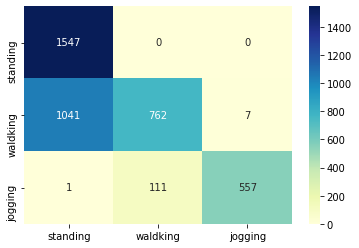

In [16]:
cm = confusion_matrix(y_train_clf, y_train_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [17]:
orig_train_acc = accuracy_score(y_train_clf, y_train_head)
orig_train_acc

0.711872826626925

#### test performance

In [18]:
y_test_head = svm_clf.predict(x_test_clf)

In [19]:
print(classification_report(y_test_clf, y_test_head, target_names=labels))

              precision    recall  f1-score   support

    standing       0.68      1.00      0.81       403
    waldking       0.77      0.34      0.47       387
     jogging       0.67      0.77      0.72       173

    accuracy                           0.69       963
   macro avg       0.71      0.71      0.67       963
weighted avg       0.72      0.69      0.66       963



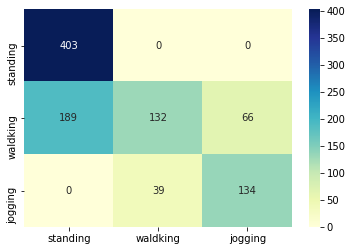

In [20]:
cm = confusion_matrix(y_test, y_test_head)
cm_df = pd.DataFrame(cm, index = labels,
                  columns = labels)
sns.heatmap(cm_df, annot=True, cmap='YlGnBu', fmt='g')

In [21]:
orig_test_acc = accuracy_score(y_test_clf, y_test_head)
orig_test_acc

0.6947040498442367

In [22]:
### GAN

In [33]:
input_shape = x_train[0].shape
discriminator = create_discriminator(input_shape);
generator = create_generator(latent_dim)
gan = create_gan(generator_model=generator, discriminator_model=discriminator)

In [34]:
train_gan(generator, discriminator, gan, x_train_activity, steps)

discriminator loss: [0.47524070739746094, 0.5625]
adversarial loss: 1.1446913480758667
discriminator loss: [2.7062668800354004, 0.5078125]
adversarial loss: 0.007845287211239338
discriminator loss: [3.228559970855713, 0.0]
adversarial loss: 0.004142973572015762
discriminator loss: [2.6423180103302, 0.0]
adversarial loss: 0.015924042090773582
discriminator loss: [2.7944960594177246, 0.0]
adversarial loss: 0.030449915677309036
discriminator loss: [2.2313661575317383, 0.0]
adversarial loss: 0.03459882736206055
discriminator loss: [2.0822885036468506, 0.0]
adversarial loss: 0.03353522717952728
discriminator loss: [2.0248992443084717, 0.0]
adversarial loss: 0.05260048806667328
discriminator loss: [1.5695509910583496, 0.0]
adversarial loss: 0.26787737011909485
discriminator loss: [0.9907701015472412, 0.0546875]
adversarial loss: 0.4000471532344818


In [35]:
## eval

In [36]:
random_latent_vectors = np.random.normal(size=(num_gen, latent_dim))
generated_sensor_data = generator.predict(random_latent_vectors)

In [37]:
gen_df = pd.DataFrame(generated_sensor_data.reshape(len(generated_sensor_data), 1, window_size).tolist(), columns= ['userAcceleration.c'])
gen_df['act'] = act_id

In [38]:
gen_windowed_df = windowing_dataframe(gen_df, window_size=window_size, step_or_sample_size=step_size, col_names=col_names, method=method)
    
input_cols = ['userAcceleration.c']
x_gen, y_gen = transform_windows_df(gen_windowed_df, input_cols=input_cols, one_hot_encode=False, as_channel=False)
x_gen = x_gen.reshape((len(x_gen), window_size))

x_train_gen = np.concatenate([x_train_clf, x_gen[:add_sample_num]])
y_train_gen = np.concatenate([y_train_clf, y_gen[:add_sample_num]])

In [39]:
svm_clf = SVC()
svm_clf.fit(x_train_gen, y_train_gen)
    
y_train_head = svm_clf.predict(x_train_clf)
train_acc = accuracy_score(y_train_clf, y_train_head)
    
y_test_head = svm_clf.predict(x_test_clf)
test_acc = accuracy_score(y_test_clf, y_test_head)

In [40]:
print('Gen Train acc:', train_acc, 'vs.', orig_train_acc, ': Orig Train Acc')
print('Gen Test acc:', test_acc, 'vs.', orig_test_acc, 'Orig Test Acc')

Gen Train acc: 0.7307501241927471 vs. 0.711872826626925 : Orig Train Acc
Gen Test acc: 0.6988577362409139 vs. 0.6947040498442367 Orig Test Acc


In [ ]:
x_train_activity, generated_sensor_data

In [42]:
import matplotlib.pyplot as plt

In [75]:
t = x_train_activity.reshape((len(x_train_activity), window_size, 1))
s = generated_sensor_data.reshape((len(generated_sensor_data), window_size, 1))

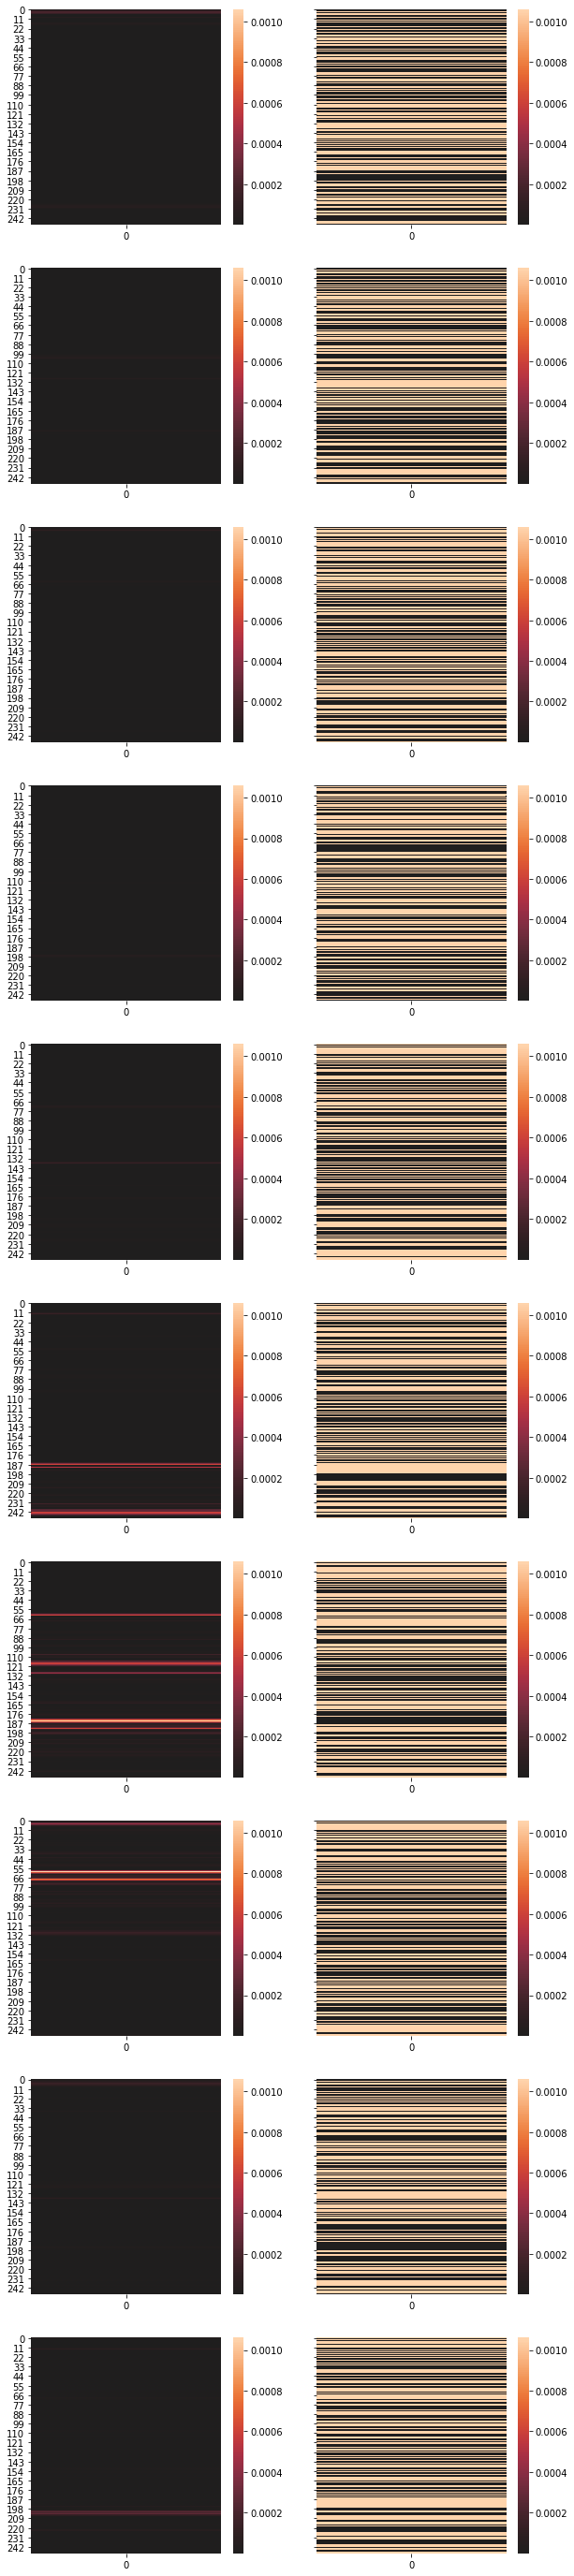

In [76]:
plot_n_heatmaps(t, s, n=10)

In [169]:
x_train_t = np.array(np.array([np.transpose(ts) for ts in x_train[:n]]))
generated_sensor_data_t = np.array([np.transpose(ts) for ts in generated_sensor_data[:n]])
time_steps = len(x_train_t[0][0])

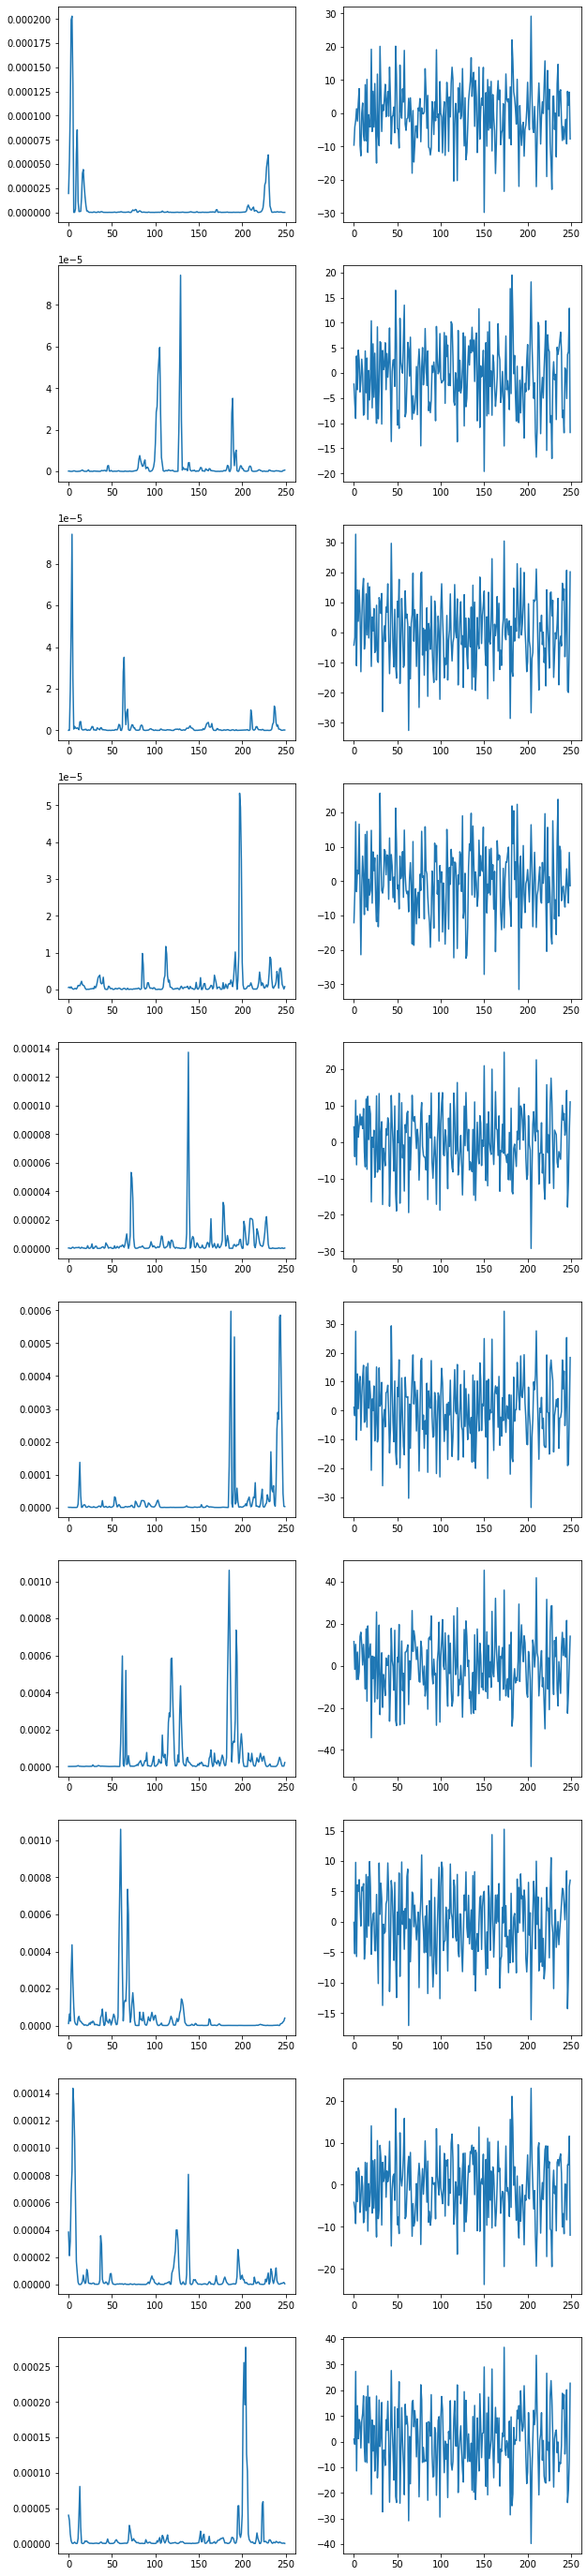

In [170]:
fig, axs = plt.subplots(ncols=2, nrows=n, figsize=(10, 5*n))
for i in range(n):
    sns.lineplot(np.arange(time_steps), x_train_t[i][0], ax=axs[i, 0])
    sns.lineplot(np.arange(time_steps), generated_sensor_data_t[i], ax=axs[i, 1])